# 自回归(AR)模型

by Maxwell Margenot, Delaney Mackenzie, and Lee Tobey

Lee Tobey is the founder of [Hedgewise](https://www.hedgewise.com/).

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)


---

## AR模型
一个自回归的，或AR$(p)$，模型是通过对其过去值的滞后时间序列进行回归而创建的。自回归模型最简单的形式是AR$(1)$模型，表示只使用一个滞后项。时间序列$x_t$的一阶自相关模型为:

$$
x_t = b_0 + b_1 x_{t - 1} + \epsilon_t
$$

其中$x_{t - 1}$表示$(t-1)$时的时间序列的值，$\epsilon_t$是误差项。我们可以将其扩展为AR$(p)$模型，表示为:

$$
x_t = b_0 + b_1 x_{t-1} + b_2 x_{t - 2} \ldots + b_p x_{t - p} + \epsilon_t
$$

为了使AR模型正常工作，我们必须要求时间序列是协方差平稳的。这意味着它符合三个条件:

1. 时间序列的期望值在任何时候都是常数和有限的，即对于所有$t$的值有$E[y_t] = \mu$和$\mu < \infty$。
2. 时间序列的方差在所有时间段内都是常数和有限的。
3. 在未来或过去一定时期内，时间序列与自身的协方差在所有时期内都是常数和有限的

$$
COV(y_t, y_{t - s}) = \lambda, \  |\lambda| < \infty, \text{ $\lambda$ constant}, \  t = 1, 2, \ \ldots, T; \  s = 0, \pm 1, \pm 2, \ldots, \pm T
$$

注意，这个数学表达式包含条件2。

如果这些条件不满足，我们的估计结果将没有现实意义。我们对参数的估计是有偏差的，这使得我们试图使用模型进行的任何测试都是无效的。不幸的是，在金融市场中找到协方差-平稳时间序列可能是一件非常痛苦的事情。例如，当我们看苹果的股票价格，我们可以清楚地看到一个上升的趋势。均值随时间增加。然而，有很多方法可以使非平稳时间序列保持平稳。一旦我们完成了这个转换，我们就可以在上面的假设下建立一个自回归模型。

## 模拟数据

在这里，我们将从一个模拟的AR$(3)$过程中提取数据样本。

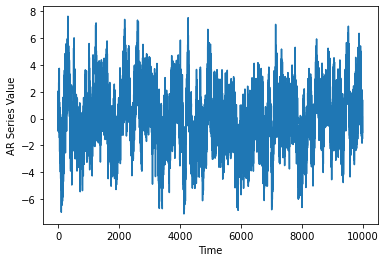

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.ar_model as tsa
import matplotlib.pyplot as plt

# ensures experiment runs the same every time
np.random.seed(100)

# This function simluates an AR process, generating a new value based on historial values,
# autoregressive coefficients b1 ... bk, and some randomness.
def AR(b, X, mu, sigma):
    l = min(len(b)-1, len(X))
    b0 = b[0]
    return b0 + np.dot(b[1:l+1], X[-l:]) + np.random.normal(mu, sigma)

b = np.array([0, 0.8, 0.1, 0.05])
X = np.array([1])
mu = 0
sigma = 1

for i in range(10000):
    X = np.append(X, AR(b, X, mu, sigma))

plt.plot(X)
plt.xlabel('Time')
plt.ylabel('AR Series Value');

请注意这个过程是如何围绕某个中心值波动的。这个值是时间序列的均值。随着时间的推移，我们有一个恒定的平均值，而波动似乎都偏离了给定的距离，我们可以假设这个系列是平稳的。我们想要在实践中严格地检验它，我们将在这节课最后的例子中简单地探讨它。也可以参见[平稳性讲座](https://www.quantopian.com/lectures/integration-cointegration-and-stationarity)。

然而，在这种情况下，我们构建的模型是平稳的，所以现在不需要担心平稳性测试。

## 尾部风险

自回归过程往往比从正态分布得出的数据有更多的极值。这是因为每个时间点的值都受到最近值的影响。如果序列随机上升，它比非自回归序列更有可能保持上升。这被称为“肥尾性”(胖尾分布)，因为pdf上的极端情况比正态分布更胖。

金融领域关于尾部风险的很多讨论都来自于这样一个事实:尾部事件确实会发生，而且由于它们的发生频率较低，因此很难建模。如果我们有理由怀疑一个过程是自回归的，那么我们应该预期极端尾部事件的风险，并做出相应的调整。

AR模型只是尾部风险的来源之一，所以不要假设因为一个系列是非AR的，它就没有尾部风险。

我们现在来检查这个行为。

In [2]:
def compare_tails_to_normal(X):
    # Define matrix to store comparisons
    A = np.zeros((2,4))    
    for k in range(4):
        #stores tail probabilities of the sample series vs a normal series
        A[0, k] = len(X[X > (k + 1)]) / float(len(X)) # Estimate tails of X        
        A[1, k] = 1 - stats.norm.cdf(k + 1) # Compare to Gaussian distribution
    print ('Frequency of std events in X \n1: %s\t2: %s\t3: %s\t4: %s' % tuple(A[0]))
    print( 'Frequency of std events in a normal process \n1: %s\t2: %s\t3: %s\t4: %s' % tuple(A[1]))
    return A

compare_tails_to_normal(X);

Frequency of std events in X 
1: 0.32756724327567244	2: 0.18548145185481452	3: 0.09099090090990901	4: 0.0357964203579642
Frequency of std events in a normal process 
1: 0.15865525393145707	2: 0.02275013194817921	3: 0.0013498980316301035	4: 3.167124183311998e-05


## 对方差的估计是错误的

由于AR过程有一个沉重的尾部和结果的非正态分布，对AR过程的方差估计将是错误的。这是危险的，因为方差是用来计算许多数量在staistics，最重要的是置信区间和p值。由于置信区间的宽度通常基于方差估计，我们不能再相信来自AR过程的p值。有关p值的更多信息，请参阅系列讲座中的[假设检验](https://www.quantopian.com/lectures)笔记本。

我们来检查一下。首先，我们将定义一些辅助函数，计算某个输入序列上的平均值的初始95%置信区间。

In [3]:
def compute_unadjusted_interval(X):
    T = len(X)
    # Compute mu and sigma MLE
    mu = np.mean(X)
    sigma = np.std(X)
    # Compute the bounds using standard error
    lower = mu - 1.96 * (sigma/np.sqrt(T))
    upper = mu + 1.96 * (sigma/np.sqrt(T))
    return lower, upper

# We'll make a function that returns true when the computed bounds contain 0
def check_unadjusted_coverage(X):
    l, u = compute_unadjusted_interval(X)
    # Check to make sure l <= 0 <= u
    if l <= 0 and u >= 0:
        return True
    else:
        return False
    
def simululate_AR_process(b, T):
    X = np.array([1])
    mu = 0
    sigma = 1
    for i in range(T):
        X = np.append(X, AR(b, X, mu, sigma))
    return X

现在我们做一个实验1000次，计算AR序列，然后估计均值，然后取一个简单的95%置信区间。然后我们将检查置信区间是否包含0，即序列的真实长期均值，并将其记录在“outcomes”数组中。

In [4]:
trials = 1000
outcomes = np.zeros((trials, 1))

for i in range(trials):
    #note these are the same values we used to generate the initial AR array
    Z = simululate_AR_process(np.array([0, 0.8, 0.1, 0.05]), 100)
    if check_unadjusted_coverage(Z):
        # The internal contains 0, the true value
        outcomes[i] = 1
    else:
        outcomes[i] = 0

最后，我们来检查一下，如果我们的测试是正确校准的，那么我们应该有95%的时间的置信区间包含0。

In [5]:
np.sum(outcomes) / trials

0.193

看起来有严重的问题。这里的情况是AR系列移动了很多，但是方差估计假设了平稳性没有考虑所有的移动。因此，置信区间比它们应该的值要小得多，并且没有包含足够的正确值。

这给了我们一种错误的安全感。平稳性测试通常应该捕捉AR行为，并让我们知道方差估计是错误的。要了解更多信息，请参阅[单整、协整与平稳性](https://www.quantopian.com/lectures).

#### 对方差进行修正

在实际中，要准确地估计AR序列上的方差是非常困难的，但有一种方法可以做到这一点，那就是新西向估计。你可以在[这里](https://en.wikipedia.org/wiki/Newey%E2%80%93West_estimator)找到相关信息.

## AR行为测试

为了确定AR$(p)$模型的阶数$p$，我们研究了时间序列的自相关。这些是该系列与其过去值的相关性。$k$阶自相关是

$$
\rho_k = \frac{COV(x_t, x_{t - k})}{\sigma_x^2} = \frac{E[(x_t - \mu)(x_{t - k} - \mu)}{\sigma_x^2}
$$

其中$k$表示滞后期的数量。我们不能直接观察自相关，所以我们估计它们为
$$
\hat{\rho}_k = \frac{\sum_{t = k + 1}^T[(x_t - \bar{x})(x_{t - k} - \bar{x})]}{\sum_{t = 1}^T (x_t - \bar{x})^2}
$$

出于我们的目的，我们可以使用一对叫做自相关函数(ACF)和部分自相关函数(PACF)的工具来确定模型的顺序。与ACF不同，PACF控制较短的滞后时间。这些函数包含在许多统计包中，并为我们计算样本自相关，使我们能够确定$p$的适当值。

我们将在上面的平稳序列的例子中演示这些函数:

In [6]:
from statsmodels.tsa.stattools import acf, pacf

In [7]:
X = simululate_AR_process(np.array([0, 0.8, 0.1, 0.05]), 1000)

In [8]:
# We'll choose 40 lags. This is a bit arbitrary, but you want to include all the lags you think might
# feasibly impact the current value.
nlags = 40
# Note, this will produce nlags + 1 values, as we include the autocorrelation of
# X[-1] with X[-1], which is trivially 1.
# The reason this is done is because that is the 0th spot in the array and corresponds
# to the 0th lag of X[(-1)-0].
X_acf = acf(X, nlags=nlags,fft=False)
print('Autocorrelations:\n',X_acf, '\n')
X_pacf = pacf(X, nlags=nlags)
print ('Partial Autocorrelations:\n' ,X_pacf)

Autocorrelations:
 [1.         0.57070553 0.58001725 0.88553976 0.55669882 0.57640436
 0.78307405 0.54759415 0.55254723 0.70158722 0.53082572 0.52673077
 0.62850967 0.50091633 0.48541475 0.56544198 0.46391848 0.45390828
 0.51491108 0.43375521 0.43938017 0.46783793 0.40843913 0.42270738
 0.42566802 0.38298857 0.38379558 0.40029717 0.36548704 0.36088258
 0.37743521 0.34745858 0.34065687 0.35239327 0.33194099 0.31758452
 0.33113111 0.31688646 0.2818213  0.31237461 0.31252031] 

Partial Autocorrelations:
 [ 1.          0.57127624  0.37827414  0.80672256  0.00162478  0.00490887
 -0.04497956  0.04013524 -0.05301909  0.00706455 -0.00528104  0.0051476
 -0.03421094 -0.03637203 -0.06841025  0.00396849 -0.02433695  0.03906542
  0.02344142  0.02958713  0.07306916 -0.01201434  0.00279546  0.01328444
 -0.00679875 -0.01547705 -0.09186641  0.05847768  0.03298422  0.04395628
 -0.01605778  0.00286143 -0.00734411 -0.01496441  0.01152254 -0.01185183
  0.01895763  0.01901218 -0.09532658  0.00791091  0.0617

现在我们来画出这些值。

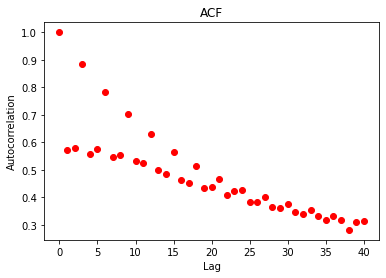

In [9]:
plt.plot(X_acf, 'ro')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title("ACF");

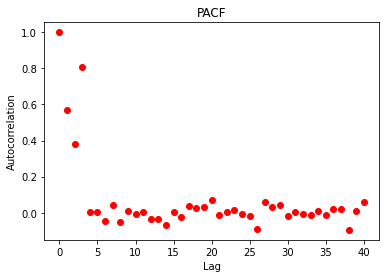

In [10]:
plt.plot(X_pacf, 'ro')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title("PACF");

#### 统计测试

仅仅看图表是不够的。我们需要使用某种程度的统计严谨性。`acf`和`pacf`函数将返回所有自相关的置信区间。我们可以检查这些区间是否与零重叠。如果是这样，那么我们就说0在真参数值的设置置信区间内，并且不认为滞后具有任何有意义的自相关。

注意:这只在置信区间计算的假设得到满足的情况下才有效。请在假定测试有意义之前检查这些假设。假设在每个情况下都是不同的，所以请阅读您自己测试的统计文档并从那里开始。

In [11]:
# We have to set a confidence level for our intervals, we choose the standard of 95%,
# corresponding with an alpha of 0.05.
X_acf, X_acf_confs = acf(X, nlags=nlags, alpha=0.05,fft=False)
X_pacf, X_pacf_confs = pacf(X, nlags=nlags, alpha=0.05)

在得到置信区间数据之后，我们将编写一个函数来绘制它。

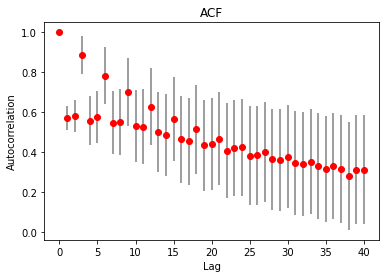

In [12]:
def plot_acf(X_acf, X_acf_confs, title='ACF'):
    # The confidence intervals are returned by the functions as (lower, upper)
    # The plotting function needs them in the form (x-lower, upper-x)
    errorbars = np.ndarray((2, len(X_acf)))
    errorbars[0, :] = X_acf - X_acf_confs[:,0]
    errorbars[1, :] = X_acf_confs[:,1] - X_acf
    plt.plot(X_acf, 'ro')
    plt.errorbar(range(len(X_acf)), X_acf, yerr=errorbars, fmt='none', ecolor='gray', capthick=2)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(title);
plot_acf(X_acf, X_acf_confs)

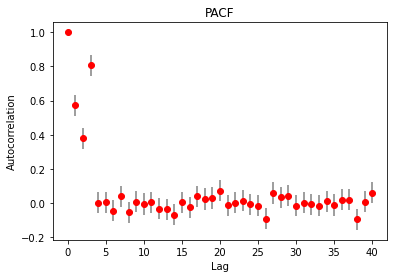

In [13]:
plot_acf(X_pacf, X_pacf_confs, title='PACF')

请注意，对于PACF，只有前三个滞后是与$0$显著不同的，这是有意义的，因为我们直接构造了一个$3$阶的AR模型。然而，这些结果可能会因每个随机产生的序列而有所不同。


在真实世界的时间序列中，我们使用这些图来确定模型的顺序。然后，我们将尝试使用最大似然函数拟合模型。

## 拟合一个模型

我们将使用Python中已经实现的一个函数来适应AR模型。我们先在模拟数据上尝试一下。

In [14]:
# Construct an unfitted model
model = tsa.AutoReg(X,lags=round(12*(len(X)/100.)**(1/4.)))
# Fit it
model = model.fit()

`model`对象有很多有用的信息，使用`?`了解更多。我们将关注几个属性，从`model.params`开始，即模型中估计的参数，每个滞后一个，以及`model.bse`，即每个参数的估计标准误差。

In [15]:
print( 'Parameters')
print( model.params)
print ('Standard Error')
print (model.bse)

Parameters
[ 0.01001762  0.04631952  0.06669125  0.84444655 -0.02662476  0.07031018
 -0.03883539  0.05362627 -0.06257934  0.03183551  0.02255835  0.06366225
 -0.02663838 -0.00824025 -0.09032174 -0.02259851 -0.05894006 -0.03575162
  0.01899755  0.0265497   0.08158745 -0.00494997]
Standard Error
[0.03174045 0.03192071 0.03184922 0.03190511 0.041767   0.04178512
 0.04180796 0.04176058 0.04174835 0.04182877 0.04184467 0.0417986
 0.04182424 0.04184715 0.04173603 0.04173417 0.04171234 0.0416686
 0.04164637 0.03181419 0.03184297 0.03191006]


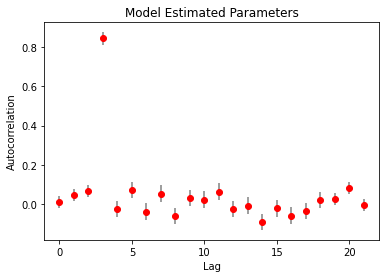

In [16]:
# To plot this we'll need to format a confidence interval 2D array like the previous functions returned
# Here is some quick code to do that
model_confs = np.asarray((model.params - model.bse, model.params + model.bse)).T

plot_acf(model.params, model_confs, title='Model Estimated Parameters')

### 选择滞后阶数

#### 估计会产生太多的滞后

我们可以看到我们的模型估计了相当多的参数。在这种情况下，我们知道有太多的，因为我们模拟的数据作为一个AR(3)过程。AR模型估计的滞后时间比实际情况要多得多，其原因是由于间接相关性。如果$X_t$依赖于$X_{t-1}$，那么它将间接地并且在较小程度上依赖于$X_{t-2}$。当数据产生过程中存在不止一个时滞时，我们将得到时滞中潜在的复杂谐波结构。这些间接的依赖关系将通过一个简单的估算得到。

#### 你需要最少的参数来生成一个像样的模型

通常情况下，你很少能从一个有很多参数的模型中得到任何有用的东西，看看过度拟合的讲座，看看为什么在量子观点系列讲座中。在这种情况下，我们希望选择一些我们认为能够解释所发生情况的滞后量，但是不要过度拟合，也不要选择滞后量过多的模型。

观察ACF和PACF表明，只有前3个滞后是有用的。但是，我们将把滞后时间扩大到10个，以复查我们的初始数据。我们将使用信息准则，特别是Akaike信息准则(AIC)和Bayes信息准则(BIC)来决定参数的正确数量。有关使用信息标准选择模型的更多信息，请参阅量子资源讲座系列中的相应讲座。

对AIC和BIC的解释如下。计算我们希望考虑的所有模型的AIC和BIC，并注意AIC和BIC中最小的$AIC_{min}$和$BIC_{min}$。这些是在每个度量下最小化信息损失的模型。对于每种类型的IC，我们可以计算每个模型的相对可能性 

$$l = e^{(IC_{min} - IC_{i})/2}$$

与最小AIC模型相比，我们可以将$l$解释为模型$i$最小化信息损失的可能性是其$1$倍。可能需要读几遍才能理解，所以让我们看看它的实际应用。

In [17]:
N = 10
AIC = np.zeros((N, 1))

for i in range(N):
    model = tsa.AutoReg(X,lags=i+1)
    model = model.fit()
    AIC[i] = model.aic

AIC_min = np.min(AIC)
model_min = np.argmin(AIC)

print ('Relative Likelihoods')
print(np.exp((AIC_min-AIC) / 2))
print ('Number of parameters in minimum AIC model %s' % (model_min+1))

Relative Likelihoods
[[0.54739169]
 [0.59052713]
 [0.99861675]
 [0.997749  ]
 [0.99628437]
 [0.99619915]
 [0.9960884 ]
 [1.        ]
 [0.99850924]
 [0.99809322]]
Number of parameters in minimum AIC model 8


In [18]:
N = 10
BIC = np.zeros((N, 1))

for i in range(N):
    model = tsa.AutoReg(X,lags=i+1)
    model = model.fit()
    BIC[i] = model.bic
    
BIC_min = np.min(BIC)
model_min = np.argmin(BIC)

print ('Relative Likelihoods')
print (np.exp((BIC_min-BIC) / 2))
print ('Number of parameters in minimum BIC model %s' % (model_min+1))

Relative Likelihoods
[[0.5508575 ]
 [0.59280494]
 [1.        ]
 [0.99666667]
 [0.99274501]
 [0.99020386]
 [0.98763995]
 [0.98905709]
 [0.9851272 ]
 [0.98226451]]
Number of parameters in minimum BIC model 3


我们的结论是AIC对4个参数模型的估计是最可能的，而BIC对3个参数模型的估计是最可能的。因为我们总是在寻找终止参数的理由，所以我们选择了3。在这种情况下，它恰好是正确答案，但情况并不总是如此，特别是在嘈杂的真实数据中。不要以为用这种方法总能得到正确的答案。

### 评估残差

在对该模型执行样本外测试之前，我们可能要做的最后一步是评估其剩余行为。AIC和BIC已经在一定程度上做到了这一点，它们有效地衡量了模型做出预测后，数据表(残差)上还剩下多少信息。有关残差分析的更多信息，请参阅回归模型的违反。这里我们检查一下残差的正态性。

In [19]:
model = tsa.AutoReg(X,lags=3)
model = model.fit()

from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(model.resid)

if pvalue < 0.10:
    print ('We have reason to suspect the residuals are not normally distributed.')
else:
    print ('The residuals seem normally distributed.')

The residuals seem normally distributed.


残差看起来是正态分布。还有更多的模型验证步骤可以完成，但这些是AR模型的核心步骤。下一步是在样本外测试模型，然后使用它对数据进行预测。

## 参考
* "Quantitative Investment Analysis", by DeFusco, McLeavey, Pinto, and Runkle
* "Analysis of Financial Time Series", by Ruey Tsay